In [2]:
! pip install -U git+https://github.com/Adapter-Hub/adapter-transformers.git
! pip install datasets

  Cloning https://github.com/Adapter-Hub/adapter-transformers.git to /tmp/pip-req-build-oz5xj_yq
  Running command git clone -q https://github.com/Adapter-Hub/adapter-transformers.git /tmp/pip-req-build-oz5xj_yq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 8.1MB/s 
     |████████████████████████████████| 901kB 42.8MB/s 
  Created wheel for adapter-transformers: filename=adapter_transformers-2.0.1-cp37-none-any.whl size=2099116 sha256=3bdb6b957543ba49b31d98725e774c815db94126b5c62a64e17cc1db06c86abc
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ccjjhd0/wheels/b0/56/c9/5bf1c51cd513412090ad751ab10fc025210176bf0a82dd8af3
Successfully built adapter-transformers
     |████████████████████████████████| 245kB 8.1MB/s 
     |████████████████████████████████| 122kB 34.3MB/s 
     |████████████████████████████████| 245kB 35.0MB/s 


In [1]:
cd drive/MyDrive/CAMemBERT-Adapters/

/content/drive/MyDrive/CAMemBERT-Adapters


Using custom data configuration default-7b4c9cd972a53327


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7b4c9cd972a53327/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


Epoch,Training Loss,Validation Loss,Loss,Spearmanr,Cohen Kappa,Pearsonr
1,No log,2.747968,2.760150,0.704687,-0.009883,-2.458775
2,No log,2.720441,2.731715,0.726415,-0.014797,-0.370482
3,No log,0.046821,0.037726,0.726297,0.040835,-0.014630
4,No log,0.011621,0.002038,0.722669,0.069996,0.402927
5,No log,0.011477,0.001876,0.731398,0.061398,0.424301


{'train_loss': 2.76015043258667, 'train_spearmanr': 0.863203888223869, 'train_cohen_kappa': -0.023581587060699905, 'train_pearsonr': -2.2488595062505827, 'eval_loss': 2.7479677200317383, 'eval_spearmanr': 0.7046871273060306, 'eval_cohen_kappa': -0.009882796980532405, 'eval_pearsonr': -2.4587750914343465}
{'train_loss': 2.7317147254943848, 'train_spearmanr': 0.9427038419772871, 'train_cohen_kappa': -0.03428777264557681, 'train_pearsonr': -0.016234555424852415, 'eval_loss': 2.7204411029815674, 'eval_spearmanr': 0.7264147751891852, 'eval_cohen_kappa': -0.014796901951499963, 'eval_pearsonr': -0.37048206006513573}
{'train_loss': 0.037726134061813354, 'train_spearmanr': 0.964507239043515, 'train_cohen_kappa': -0.022710666857491457, 'train_pearsonr': 0.4315664001399163, 'eval_loss': 0.04682062193751335, 'eval_spearmanr': 0.7262966034848607, 'eval_cohen_kappa': 0.04083529034111055, 'eval_pearsonr': -0.014630006407302165}
{'train_loss': 0.0020378176122903824, 'train_spearmanr': 0.97620087990311

{'eval_loss': 0.009726558811962605, 'eval_spearmanr': 0.7636546777710917, 'eval_cohen_kappa': 0.0473396929041473, 'eval_pearsonr': 0.5238570179895927}
_________plotting history__________
defaultdict(<class 'list'>, {('_loss', 'train'): [2.76015043258667, 2.7317147254943848, 0.037726134061813354, 0.0020378176122903824, 0.0018760657403618097], ('_spearmanr', 'train'): [0.863203888223869, 0.9427038419772871, 0.964507239043515, 0.976200879903111, 0.9817157581698547], ('_cohen_kappa', 'train'): [-0.023581587060699905, -0.03428777264557681, -0.022710666857491457, 0.1415841752527648, 0.12451739093460323], ('_pearsonr', 'train'): [-2.2488595062505827, -0.016234555424852415, 0.4315664001399163, 0.8856573259845153, 0.8967097023333598], ('_loss', 'eval'): [2.7479677200317383, 2.7204411029815674, 0.04682062193751335, 0.011621365323662758, 0.011476713232696056], ('_spearmanr', 'eval'): [0.7046871273060306, 0.7264147751891852, 0.7262966034848607, 0.7226685140805457, 0.7313984607586264], ('_cohen_kap

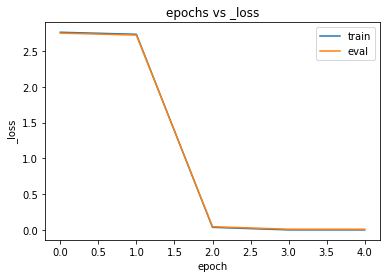

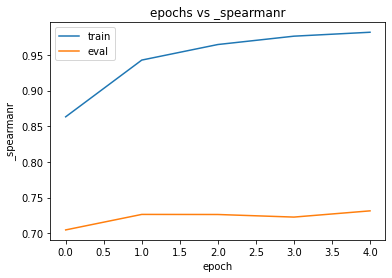

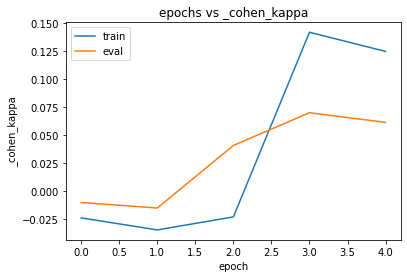

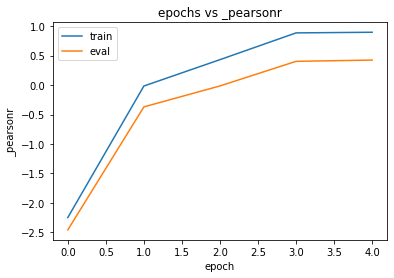

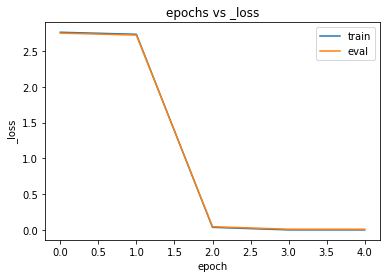

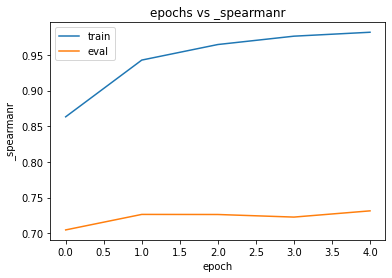

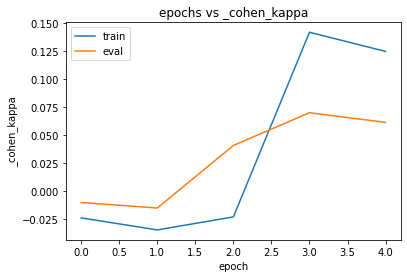

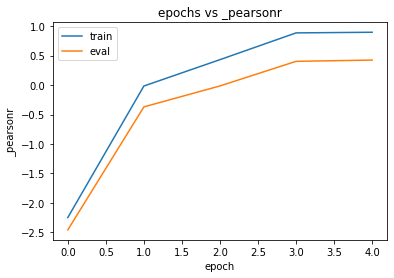

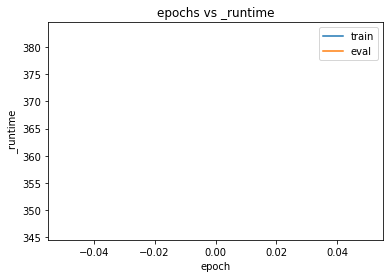

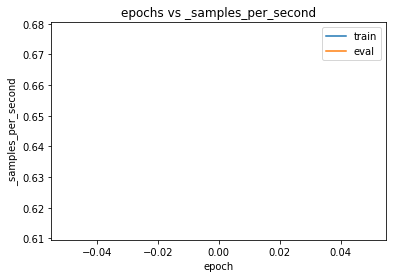

In [7]:
# import os, sys
# currentdir = os.path.dirname(os.path.realpath(__file__))
# preprocess_mod_ind = currentdir.split('/').index('CAMemBERT-Adapters')
# preprocess_mod_path = '/'.join(currentdir.split('/')[:preprocess_mod_ind+1])
# sys.path.append(preprocess_mod_path)
from transformers import AutoTokenizer,EarlyStoppingCallback,TrainingArguments
from datasets import load_dataset,load_metric
from src.utils.preprocessing import read_pickle_file
from src.models.transformer_models import R2BERT
from src.models.trainers import R2Trainer
from src.models.running import *
from sklearn.metrics import r2_score,cohen_kappa_score
import torch

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch[tokenize_col], max_length=max_n_tokens, truncation=True, padding="max_length")

def compute_metrics(p):
    #####################################################
    # Here is where the error lies p.predictions returns only 30 
    # predictions for the training arguments and parameters set below
    logits, labels = p.predictions,p.label_ids
    metrics_dic = metric.compute(predictions=logits, references=labels)
    metrics_dic['cohen_kappa'] = cohen_kappa_score(logits,labels)
    metrics_dic['pearsonr'] = r2_score(labels, logits)
    return metrics_dic

es = 2
lr = 4e-5
bs = 16
epochs = 5
frozen_layers = 1
metric_for_best_model = 'pearsonr'
dev = True

tokenize_col='essays'
max_n_tokens=512
extra_cols_for_dataset=['essay_set','norm_scores']

params = generate_parameters(es,lr,bs,epochs,frozen_layers,metric_for_best_model,dev,max_n_tokens)

pre_trained_model_name = 'bert-base-uncased'
dataset_title = 'fce_essays'
task = 'aes'
subtask = 'regression'
abrev_name = f'r2_bert_{dataset_title}'

file_paths = generate_file_paths(dataset_title,task,subtask,params,abrev_name)

dataset_dic = {'train':file_paths['train_file_path'],'test':file_paths['test_file_path'],'val':file_paths['val_file_path']}

dataset = load_dataset('csv', data_files=dataset_dic)
tokenizer = AutoTokenizer.from_pretrained(pre_trained_model_name)
dataset = dataset.map(encode_batch, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask","labels"]+extra_cols_for_dataset)

min_max_dic = {}
min_max_dic['min_scores'] = {1:0}
min_max_dic['ranges'] = {1:40}

model = R2BERT(pre_trained_model_name,norm_params=min_max_dic,dynamic=True)
model.set_trainable_params(params['frozen_layers'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

metric = load_metric("spearmanr")

training_args = base_training_args(params,file_paths)

callbacks = [EarlyStoppingCallback(es)]

trainer = R2Trainer(model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    compute_metrics=compute_metrics,
    callbacks=callbacks,)

trainer.train()

print()
print('__________test set results__________')
trainer.evaluate(dataset['test'],testing=True)
hist = trainer.state.log_history[-1]
eval_data = generate_eval_data(hist,params,task,subtask,pre_trained_model_name)
update_evaluation_results_for_this_model(f'{file_paths["evaluation_file_this_model"]}',eval_data)
update_evaluation_results_for_subtask(file_paths)

print('_________plotting history__________')
trainer.plot_history(file_paths['plots_path'],f'{file_paths["full_model_name"]}')

In [6]:
import pandas as pd
pd.read_csv(file_paths['train_file_path'])

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,essays,labels,essay_set,norm_scores
0,208,61,239,118,"Dear Sir, I would like to show you how disapp...",30,1,0.750
1,259,702,504,704,"Dear Helen Ryan, Thank you very much for let...",27,1,0.675
2,97,86,603,847,"Dear Mrs Helen Ryan, Thank you very much for ...",36,1,0.900
3,148,131,595,1174,"Dear Maria, I'm so happy to help you for this...",27,1,0.675
4,395,620,392,940,Dear Helen Ryan: My name is Julia Sanches and...,29,1,0.725
...,...,...,...,...,...,...,...,...
741,71,744,435,1205,"12th June 2001 Dar Mrs. Maria Smith, I am ver...",17,1,0.425
742,106,300,284,969,"Dear Helen Ryan, I am very pleased to hear th...",39,1,0.975
743,270,177,292,857,"Dear Ms Ryan, I am the person who won your co...",35,1,0.875
744,435,45,66,958,13 of June 2000 Dear Helen Ryan: I will be ve...,25,1,0.625
